The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install -U mxnet-cu101==1.7.0
!pip install d2l==0.17.5


# Optimization and Deep Learning

In this section, we will discuss the relationship between optimization and deep learning as well as the challenges of using optimization in deep learning.
For a deep learning problem, we will usually define a *loss function* first. Once we have the loss function, we can use an optimization algorithm in attempt to minimize the loss.
In optimization, a loss function is often referred to as the *objective function* of the optimization problem. By tradition and convention most optimization algorithms are concerned with *minimization*. If we ever need to maximize an objective there is a simple solution: just flip the sign on the objective.

## Goal of Optimization

Although optimization provides a way to minimize the loss function for deep
learning, in essence, the goals of optimization and deep learning are
fundamentally different.
The former is primarily concerned with minimizing an
objective whereas the latter is concerned with finding a suitable model, given a
finite amount of data.
In :numref:`sec_model_selection`,
we discussed the difference between these two goals in detail.
For instance,
training error and generalization error generally differ: since the objective
function of the optimization algorithm is usually a loss function based on the
training dataset, the goal of optimization is to reduce the training error.
However, the goal of deep learning (or more broadly, statistical inference) is to
reduce the generalization error.
To accomplish the latter we need to pay
attention to overfitting in addition to using the optimization algorithm to
reduce the training error.


In [1]:
%matplotlib inline
from mpl_toolkits import mplot3d
from mxnet import np, npx
from d2l import mxnet as d2l

npx.set_np()

To illustrate the aforementioned different goals,
let us consider 
the empirical risk and the risk. 
As described
in :numref:`subsec_empirical-risk-and-risk`,
the empirical risk
is an average loss
on the training dataset
while the risk is the expected loss 
on the entire population of data.
Below we define two functions:
the risk function `f`
and the empirical risk function `g`.
Suppose that we have only a finite amount of training data.
As a result, here `g` is less smooth than `f`.


In [2]:
def f(x):
    return x * np.cos(np.pi * x)

def g(x):
    return f(x) + 0.2 * np.cos(5 * np.pi * x)

The graph below illustrates that the minimum of the empirical risk on a training dataset may be at a different location from the minimum of the risk (generalization error).


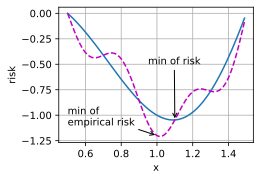

In [3]:
def annotate(text, xy, xytext):  #@save
    d2l.plt.gca().annotate(text, xy=xy, xytext=xytext,
                           arrowprops=dict(arrowstyle='->'))

x = np.arange(0.5, 1.5, 0.01)
d2l.set_figsize((4.5, 2.5))
d2l.plot(x, [f(x), g(x)], 'x', 'risk')
annotate('min of\nempirical risk', (1.0, -1.2), (0.5, -1.1))
annotate('min of risk', (1.1, -1.05), (0.95, -0.5))

## Optimization Challenges in Deep Learning

In this chapter, we are going to focus specifically on the performance of optimization algorithms in minimizing the objective function, rather than a
model's generalization error. 
In :numref:`sec_linear_regression`
we distinguished between analytical solutions and numerical solutions in
optimization problems. 
In deep learning, most objective functions are
complicated and do not have analytical solutions. Instead, we must use numerical
optimization algorithms. 
The optimization algorithms in this chapter
all fall into this
category.

There are many challenges in deep learning optimization. Some of the most vexing ones are local minima, saddle points, and vanishing gradients. 
Let us have a look at them.


### Local Minima

For any objective function $f(x)$,
if the value of $f(x)$ at $x$ is smaller than the values of $f(x)$ at any other points in the vicinity of $x$, then $f(x)$ could be a local minimum.
If the value of $f(x)$ at $x$ is the minimum of the objective function over the entire domain,
then $f(x)$ is the global minimum.

For example, given the function

$$f(x) = x \cdot \text{cos}(\pi x) \text{ for } -1.0 \leq x \leq 2.0,$$

we can approximate the local minimum and global minimum of this function.


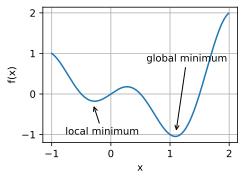

In [4]:
x = np.arange(-1.0, 2.0, 0.01)
d2l.plot(x, [f(x), ], 'x', 'f(x)')
annotate('local minimum', (-0.3, -0.25), (-0.77, -1.0))
annotate('global minimum', (1.1, -0.95), (0.6, 0.8))

The objective function of deep learning models usually has many local optima. 
When the numerical solution of an optimization problem is near the local optimum, the numerical solution obtained by the final iteration may only minimize the objective function *locally*, rather than *globally*, as the gradient of the objective function's solutions approaches or becomes zero. 
Only some degree of noise might knock the parameter out of the local minimum. In fact, this is one of the beneficial properties of
minibatch stochastic gradient descent where the natural variation of gradients over minibatches is able to dislodge the parameters from local minima.


### Saddle Points

Besides local minima, saddle points are another reason for gradients to vanish. A *saddle point* is any location where all gradients of a function vanish but which is neither a global nor a local minimum. 
Consider the function $f(x) = x^3$. Its first and second derivative vanish for $x=0$. Optimization might stall at this point, even though it is not a minimum.


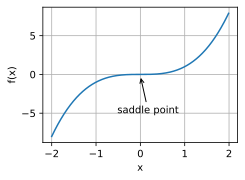

In [5]:
x = np.arange(-2.0, 2.0, 0.01)
d2l.plot(x, [x**3], 'x', 'f(x)')
annotate('saddle point', (0, -0.2), (-0.52, -5.0))

Saddle points in higher dimensions are even more insidious, as the example below shows. Consider the function $f(x, y) = x^2 - y^2$. It has its saddle point at $(0, 0)$. This is a maximum with respect to $y$ and a minimum with respect to $x$. Moreover, it *looks* like a saddle, which is where this mathematical property got its name.


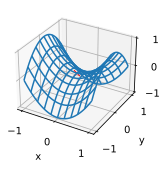

In [6]:
x, y = np.meshgrid(
    np.linspace(-1.0, 1.0, 101), np.linspace(-1.0, 1.0, 101))
z = x**2 - y**2
ax = d2l.plt.figure().add_subplot(111, projection='3d')
ax.plot_wireframe(x.asnumpy(), y.asnumpy(), z.asnumpy(),
                  **{'rstride': 10, 'cstride': 10})
ax.plot([0], [0], [0], 'rx')
ticks = [-1, 0, 1]
d2l.plt.xticks(ticks)
d2l.plt.yticks(ticks)
ax.set_zticks(ticks)
d2l.plt.xlabel('x')
d2l.plt.ylabel('y');

We assume that the input of a function is a $k$-dimensional vector and its
output is a scalar, so its Hessian matrix will have $k$ eigenvalues
(refer to the [online appendix on eigendecompositions](https://d2l.ai/chapter_appendix-mathematics-for-deep-learning/eigendecomposition.html)).
The solution of the
function could be a local minimum, a local maximum, or a saddle point at a
position where the function gradient is zero:

* When the eigenvalues of the function's Hessian matrix at the zero-gradient position are all positive, we have a local minimum for the function.
* When the eigenvalues of the function's Hessian matrix at the zero-gradient position are all negative, we have a local maximum for the function.
* When the eigenvalues of the function's Hessian matrix at the zero-gradient position are negative and positive, we have a saddle point for the function.

For high-dimensional problems the likelihood that at least *some* of the eigenvalues are negative is quite high. This makes saddle points more likely than local minima. We will discuss some exceptions to this situation in the next section when introducing convexity. In short, convex functions are those where the eigenvalues of the Hessian are never negative. Sadly, though, most deep learning problems do not fall into this category. Nonetheless it is a great tool to study optimization algorithms.

### Vanishing Gradients

Probably the most insidious problem to encounter is the vanishing gradient.
Recall our commonly-used activation functions and their derivatives in :numref:`subsec_activation-functions`.
For instance, assume that we want to minimize the function $f(x) = \tanh(x)$ and we happen to get started at $x = 4$. As we can see, the gradient of $f$ is close to nil.
More specifically, $f'(x) = 1 - \tanh^2(x)$ and thus $f'(4) = 0.0013$.
Consequently, optimization will get stuck for a long time before we make progress. This turns out to be one of the reasons that training deep learning models was quite tricky prior to the introduction of the ReLU activation function.


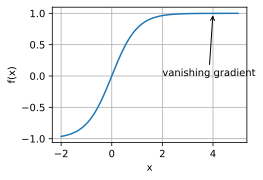

In [7]:
x = np.arange(-2.0, 5.0, 0.01)
d2l.plot(x, [np.tanh(x)], 'x', 'f(x)')
annotate('vanishing gradient', (4, 1), (2, 0.0))

As we saw, optimization for deep learning is full of challenges. Fortunately there exists a robust range of algorithms that perform well and that are easy to use even for beginners. Furthermore, it is not really necessary to find *the* best solution. Local optima or even approximate solutions thereof are still very useful.

## Summary

* Minimizing the training error does *not* guarantee that we find the best set of parameters to minimize the generalization error.
* The optimization problems may have many local minima.
* The problem may have even more saddle points, as generally the problems are not convex.
* Vanishing gradients can cause optimization to stall. Often a reparameterization of the problem helps. Good initialization of the parameters can be beneficial, too.


## Exercises

1. Consider a simple MLP with a single hidden layer of, say, $d$ dimensions in the hidden layer and a single output. Show that for any local minimum there are at least $d!$ equivalent solutions that behave identically.
1. Assume that we have a symmetric random matrix $\mathbf{M}$ where the entries
   $M_{ij} = M_{ji}$ are each drawn from some probability distribution
   $p_{ij}$. Furthermore assume that $p_{ij}(x) = p_{ij}(-x)$, i.e., that the
   distribution is symmetric (see e.g., :cite:`Wigner.1958` for details).
    1. Prove that the distribution over eigenvalues is also symmetric. That is, for any eigenvector $\mathbf{v}$ the probability that the associated eigenvalue $\lambda$ satisfies $P(\lambda > 0) = P(\lambda < 0)$.
    1. Why does the above *not* imply $P(\lambda > 0) = 0.5$?
1. What other challenges involved in deep learning optimization can you think of?
1. Assume that you want to balance a (real) ball on a (real) saddle.
    1. Why is this hard?
    1. Can you exploit this effect also for optimization algorithms?


[Discussions](https://discuss.d2l.ai/t/349)
